In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
sns.set(style='darkgrid')
from pipe import Pipe

%matplotlib inline
import pylab as pl


In [3]:
test_log_file = '20180211_test_log.csv'
data_dir = './20180211/'
channel_mapper= dict(
    a='sig_gen',
    b='res_volt',
    c='rec_volt',
    d='sec_volt'
)
df_log = pd.read_csv(test_log_file).drop(['test_no'], axis=1)
df_log = df_log.rename(columns=dict(primary_position='pos'))

df_log.head()

,sample,fatique_life,bends,pos,file_name
0,cs_90,0.9,393,12,20180211-0001.csv
1,cs_90,0.9,393,16,20180211-0002.csv
2,cs_90,0.9,393,20,20180211-0003.csv
3,cs_90,0.9,393,24,20180211-0004.csv
4,cs_90,0.9,393,28,20180211-0005.csv


In [4]:
def get_data(reload=False):
    if reload:
        df = None
        for (pipe_label, pos), batch in df_log.groupby(by=['sample', 'fatique_life']):
            p = Pipe(pipe_label, batch, channel_mapper, data_dir=data_dir, n_jobs=2, harmonic=3)
            p.process()
            if df is None:
                df = p.df
            else:
                df = df.append(p.df, ignore_index=True)
        df.to_csv('results.txt', index=False)
    df = pd.read_csv('./results.txt')
    return df

df = get_data(reload=True)
df.head(3)

Processing cs_100, 44, ./20180211/20180211-0033.csv
Processing cs_100, 16, ./20180211/20180211-0026.csv
Processing cs_100, 28, ./20180211/20180211-0029.csv
Processing cs_100, 20, ./20180211/20180211-0027.csv
Processing cs_100, 48, ./20180211/20180211-0034.csv
Processing cs_100, 52, ./20180211/20180211-0035.csv
Processing cs_100, 32, ./20180211/20180211-0030.csv
Processing cs_100, 12, ./20180211/20180211-0025.csv
Processing cs_100, 24, ./20180211/20180211-0028.csv
Processing cs_100, 36, ./20180211/20180211-0031.csv
Processing cs_100, 40, ./20180211/20180211-0032.csv
Processing cs_100, 56, ./20180211/20180211-0036.csv
Processing cs_100_b, 52, ./20180211/20180211-0083.csv
Processing cs_100_b, 36, ./20180211/20180211-0079.csv
Processing cs_100_b, 28, ./20180211/20180211-0077.csv
Processing cs_100_b, 44, ./20180211/20180211-0081.csv
Processing cs_100_b, 24, ./20180211/20180211-0076.csv
Processing cs_100_b, 56, ./20180211/20180211-0084.csv
Processing cs_100_b, 16, ./20180211/20180211-0074.cs

,pipe,pos,prim_sec_amp,prim_sec_phi,prim_rec_amp,prim_rec_phi,sec_rec_amp,sec_rec_phi,sec_harm_db,rec_harm_db
0,cs_100,12,0.010480,0.461746,0.010965,1.095136,1.046314,0.633391,-42.797880,-19.646412
1,cs_100,16,0.010590,0.495349,0.010377,1.163200,0.979850,0.667851,-42.303046,-20.593899
2,cs_100,20,0.010436,0.505915,0.009789,1.195691,0.938012,0.689776,-42.174307,-20.810280


In [5]:
def get_col(df, col_name):
    df = df.pivot(index='pos', columns='pipe', values=col_name)
    df = df.reset_index(drop=False)
    df.index.name = col_name
    df.columns.name = None
    return df

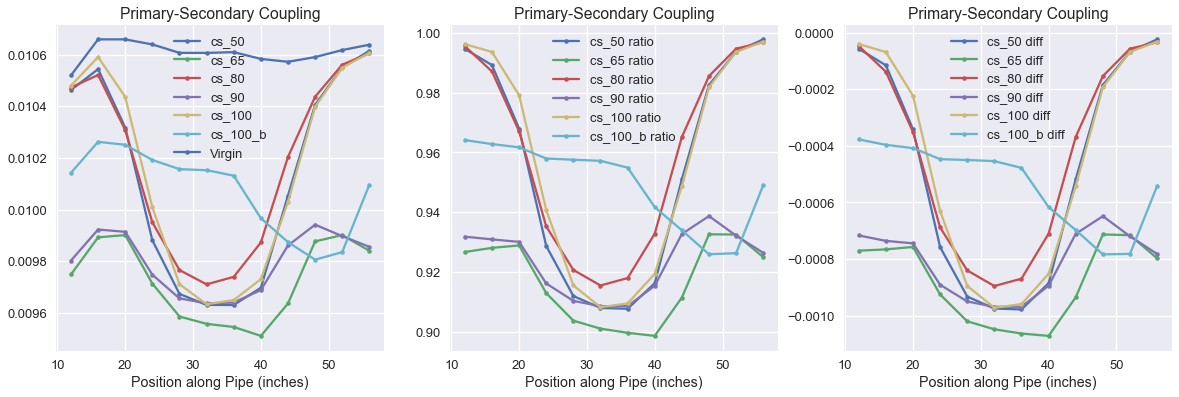

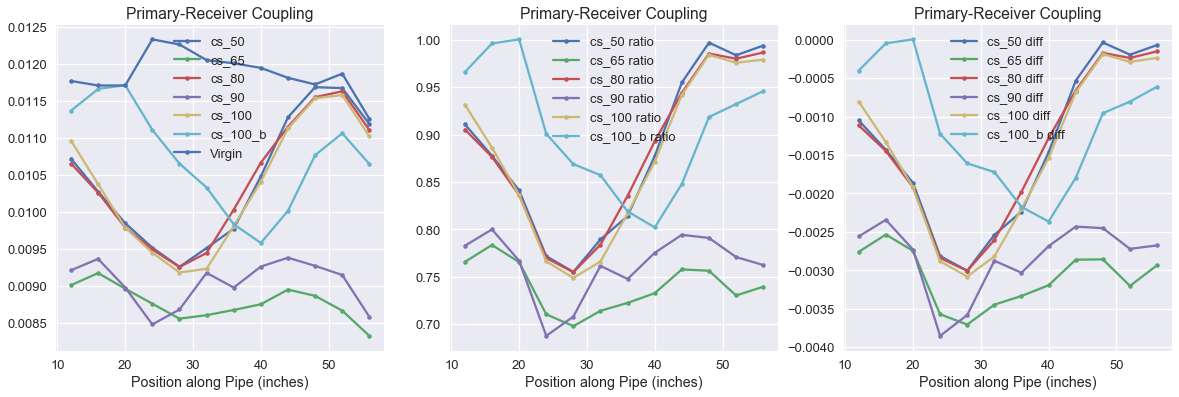

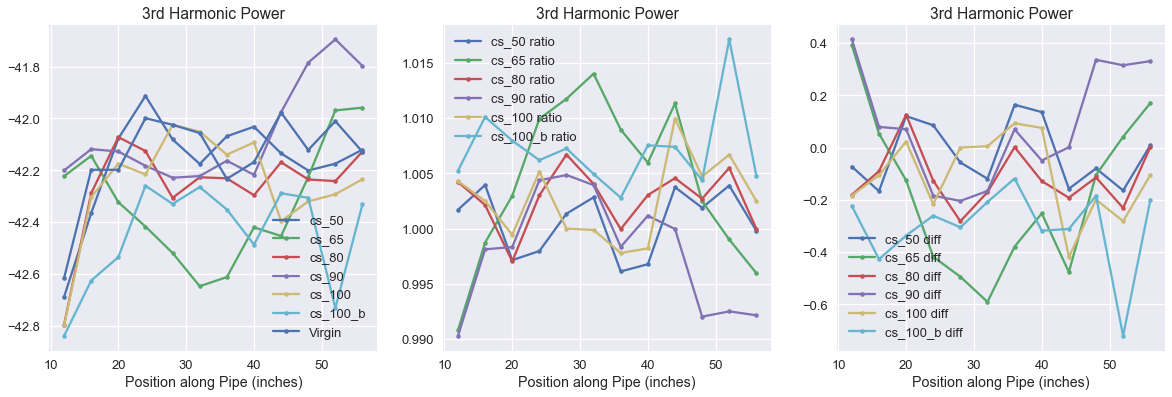

In [8]:
def do_plot(df, field_name, pipe_labels, title=None, ylabel=None):
    xlabel = 'Position along Pipe (inches)'
    dfx = get_col(df, field_name)
    pl.rcParams['figure.figsize'] = (20, 6)
    sns.set_context('talk')
    
    pl.subplot(131)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label], '.-', label=pipe_label, )
    pl.plot(dfx.pos, dfx.virgin, '.-', label='Virgin', )
    pl.legend(loc='best')
    pl.xlabel(xlabel)
    if ylabel is not None:
        pl.title(title);
        
    pl.subplot(132)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] / dfx.virgin, '.-', label=f'{pipe_label} ratio')
    pl.xlabel(xlabel)
    pl.legend(loc='best')
    pl.title(title)
    pl.subplot(133)
    for pipe_label in pipe_labels:
        pl.plot(dfx.pos, dfx[pipe_label] - dfx.virgin, '.-', label=f'{pipe_label} diff')
    pl.xlabel(xlabel)
    pl.title(title)
    pl.legend(loc='best')

pipe_labels = [
    'cs_50',
    'cs_65',
    'cs_80',
    'cs_90',
    'cs_100',
    'cs_100_b',
]
pl.figure()
do_plot(df, 'prim_sec_amp', pipe_labels, title='Primary-Secondary Coupling', ylabel='Mutual Inductance')

pl.figure()
do_plot(df, 'prim_rec_amp', pipe_labels, title='Primary-Receiver Coupling', ylabel='Mutual Inductance')
pl.figure()
do_plot(df, 'sec_harm_db', pipe_labels, title='3rd Harmonic Power', ylabel='dB')



In [10]:
def plotter(*args, **kwargs):
    pl.scatter(*args, **kwargs)
    pl.plot(*args, **kwargs)

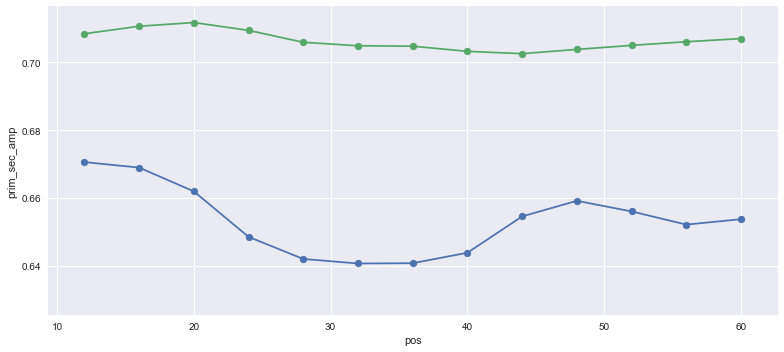

In [11]:
g = sns.FacetGrid(df, hue='pipe', sharey=False, size=5, aspect=2.2, legend_out=True)
g.map(plotter, 'pos', 'prim_sec_amp')

In [87]:
dfr = pd.read_csv('dfr.csv').sort_values(by=['sample', 'pos'])
dfr.head()

,sample,pos,prim_rec_amp,prim_sec_amp,sec_rec_amp,prim_rec_phi,prim_sec_phi,sec_rec_phi,h_db_sec,h_db_rec
0,broken,-39,14.622019,10.051393,1.454726,-0.715641,-1.368847,0.653206,-41.381120,-27.656500
1,broken,-35,20.731454,14.126361,1.467572,-0.588626,-1.233961,0.645335,-40.641068,-27.589750
2,broken,-31,21.864260,14.791238,1.478190,-0.537016,-1.184731,0.647714,-40.307470,-27.834078
3,broken,-27,21.852928,14.878886,1.468721,-0.514831,-1.167133,0.652302,-40.542364,-27.837927
4,broken,-23,21.814354,14.911596,1.462912,-0.504493,-1.162271,0.657779,-40.656154,-27.661548


In [88]:
dfx = dfr.set_index(['pos', 'sample']).unstack('sample').sort_index(axis=1)
# dfx.columns = dfx.columns.swaplevel()
dfx.sort_index(axis=1).reset_index().head()

pos   h_db_rec              h_db_sec            prim_rec_amp  \
sample         broken     virgin     broken     virgin       broken   
0      -39 -27.656500 -26.366105 -41.381120 -41.249427    14.622019   
1      -35 -27.589750 -27.059345 -40.641068 -40.196454    20.731454   
2      -31 -27.834078 -27.363808 -40.307470 -40.355817    21.864260   
3      -27 -27.837927 -27.386673 -40.542364 -40.329838    21.852928   
4      -23 -27.661548 -27.526986 -40.656154 -40.417398    21.814354   

                  prim_rec_phi           prim_sec_amp            prim_sec_phi  \
sample     virgin       broken    virgin       broken     virgin       broken   
0       14.472237    -0.715641 -0.735573    10.051393  10.025023    -1.368847   
1       20.232075    -0.588626 -0.611196    14.126361  14.063553    -1.233961   
2       21.463994    -0.537016 -0.552826    14.791238  14.803930    -1.184731   
3       21.587709    -0.514831 -0.526315    14.878886  14.912490    -1.167133   
4       21.561078    -0.504493 -0.520239    14.911596  14.873160    -1.162271   

                 sec_rec_amp           sec_rec_phi            
sample    virgin      broken    virgin      broken    virgin  
0      -1.375350    1.454726  1.443611    0.653206  0.639777  
1      -1.245438    1.467572  1.438618    0.645335  0.634242  
2      -1.193896    1.478190  1.449885    0.647714  0.641069  
3      -1.176524    1.468721  1.447626    0.652302  0.650210  
4      -1.170036    1.462912  1.449664    0.657779  0.649797

In [89]:
diff_dict = {}
for var in dfx.columns.levels[0]:
    dfd = dfx.loc[:, pd.IndexSlice[var]]
    diff_dict[var] = (dfd['broken'] - dfd['virgin'])
    
dfp = pd.melt(pd.DataFrame(diff_dict).reset_index(), id_vars='pos')
dfp.head()

,pos,variable,value
0,-39,h_db_rec,-1.290395
1,-35,h_db_rec,-0.530405
2,-31,h_db_rec,-0.470270
3,-27,h_db_rec,-0.451254
4,-23,h_db_rec,-0.134562


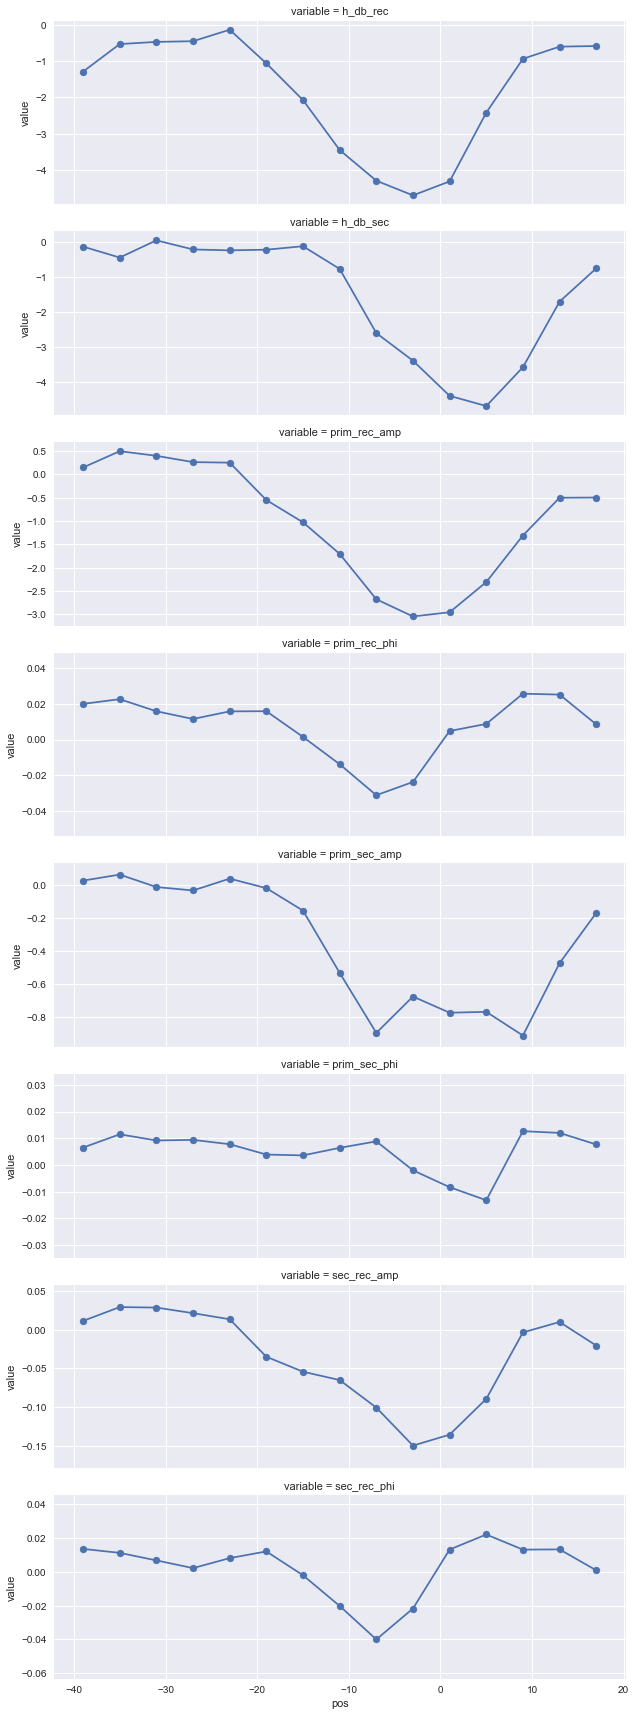

In [90]:
g = sns.FacetGrid(dfp, row='variable', sharey=False, size=3, aspect=3)
g.map(plotter, 'pos', 'value')
pl.savefig('rob.png')

In [78]:
pl.savefig(fig, 'rob.pdf')

TypeError: print_figure() got multiple values for argument 'dpi'

In [57]:
dfx.columns.swaplevel()

MultiIndex(levels=[['broken', 'virgin'], ['hfrac_rec', 'hfrac_sec', 'prim_rec_amp', 'prim_rec_phi', 'prim_sec_amp', 'prim_sec_phi', 'sec_rec_amp', 'sec_rec_phi']],
           labels=[[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]],
           names=['sample', None])

In [50]:
dfx = pd.melt(dfr, id_vars=['sample', 'pos'])
dfx.head()

,sample,pos,variable,value
0,broken,-39,z_prim_rec_amp,14.622019
1,broken,-35,z_prim_rec_amp,20.731454
2,broken,-31,z_prim_rec_amp,21.864260
3,broken,-27,z_prim_rec_amp,21.852928
4,broken,-23,z_prim_rec_amp,21.814354


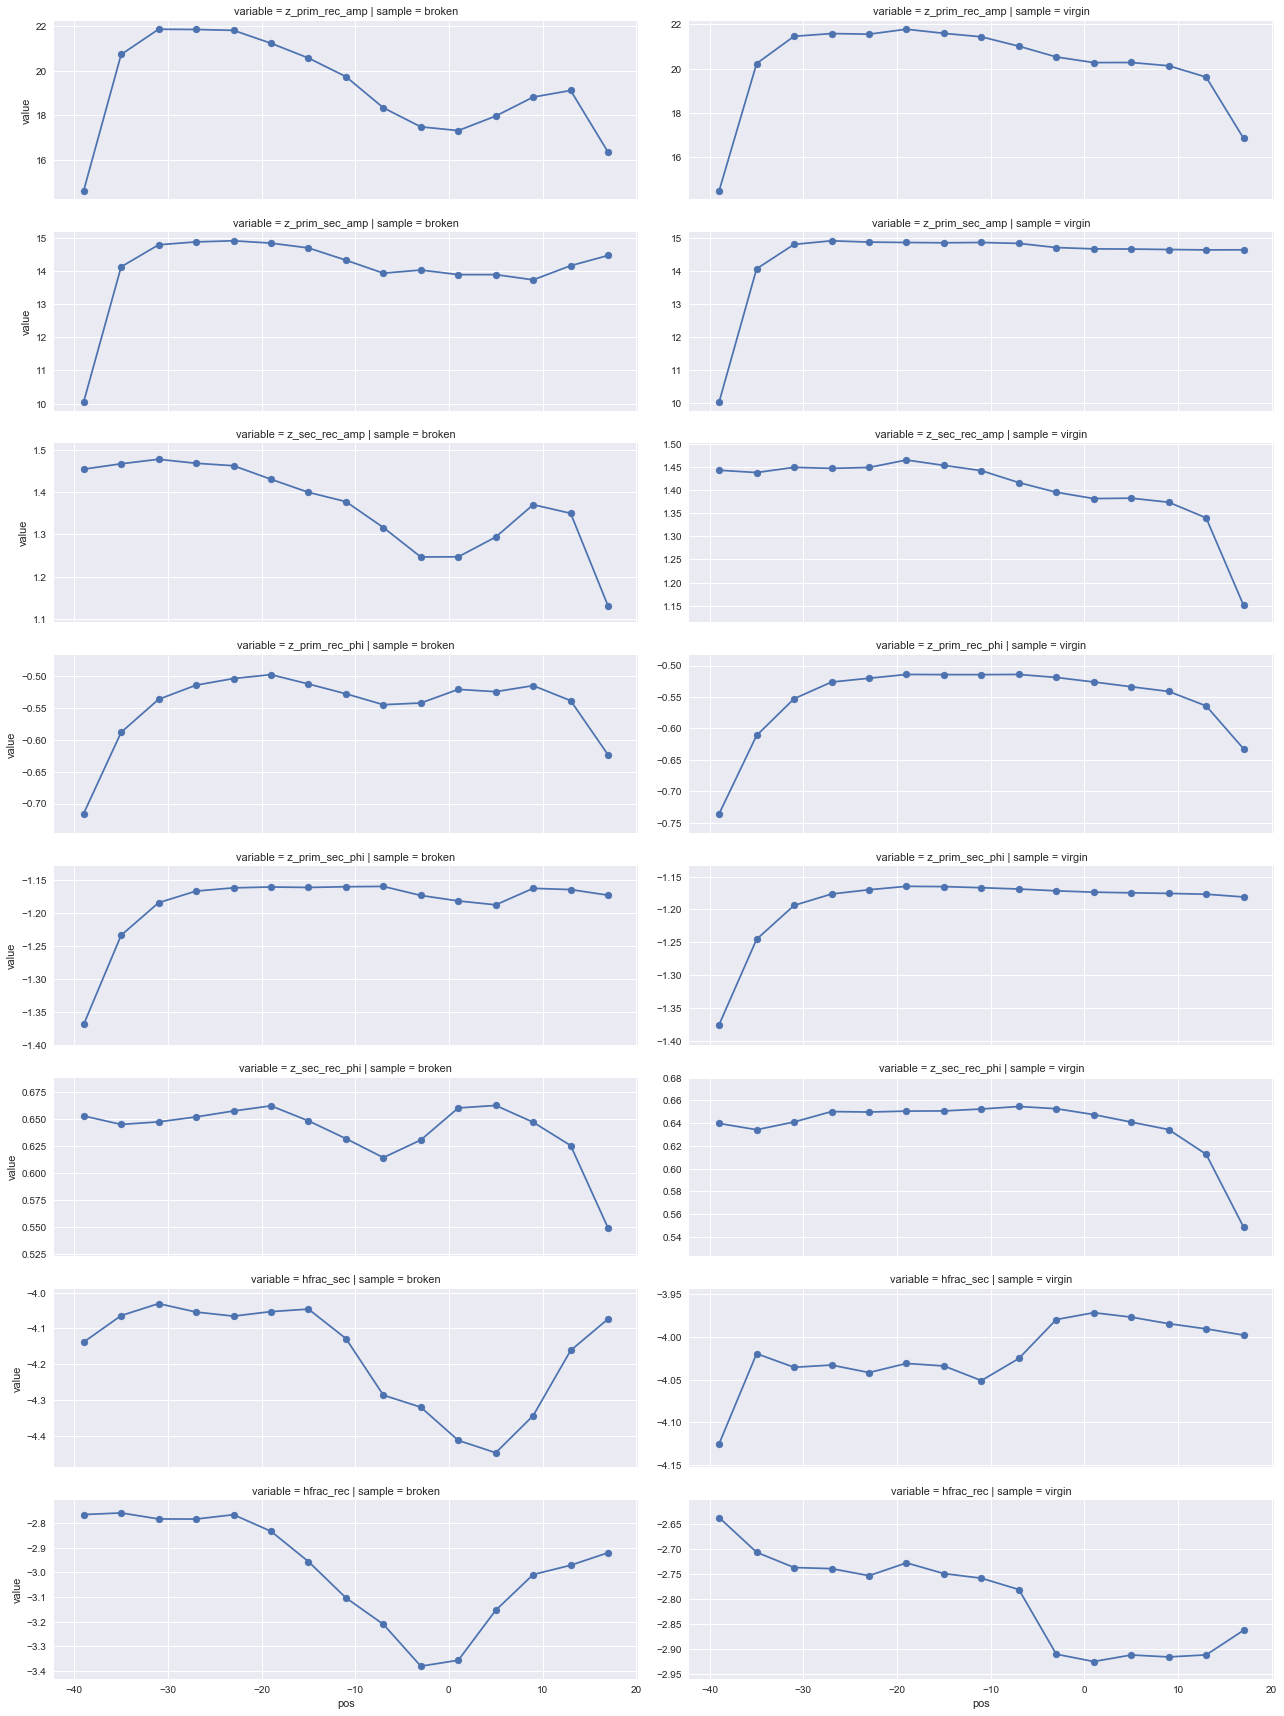

In [51]:
g = sns.FacetGrid(dfx, col='sample', row='variable', sharey=False, size=3, aspect=3)
g.map(plotter, 'pos', 'value')

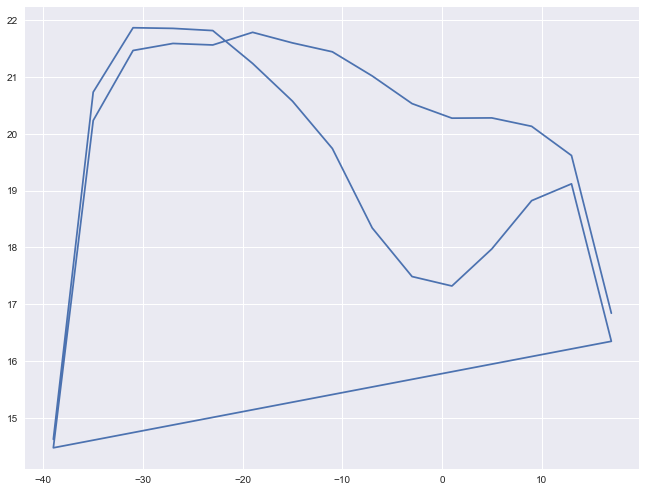

In [38]:
pl.plot(dfr.pos, dfr.z_prim_rec_amp)

In [ ]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)


In [43]:
def plotter(*args, **kwargs):
    pl.scatter(*args, **kwargs)
    pl.plot(*args, **kwargs)

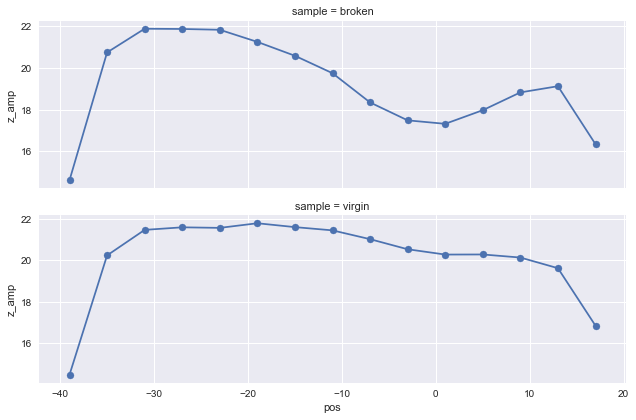

In [14]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

g.map(plotter , 'pos', 'z_amp')
pl.savefig('z_amp.pdf')

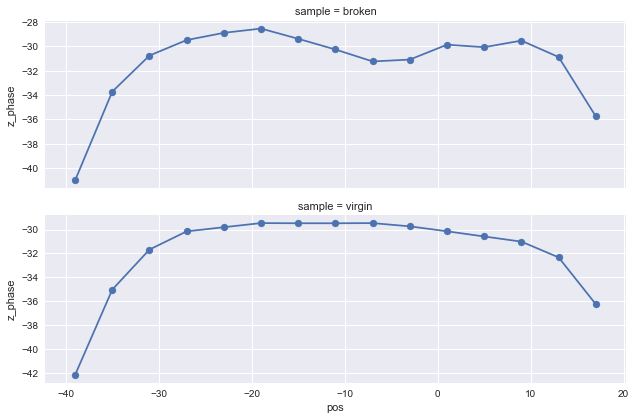

In [15]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

g.map(plotter , 'pos', 'z_phase')
pl.savefig('z_phase.pdf')

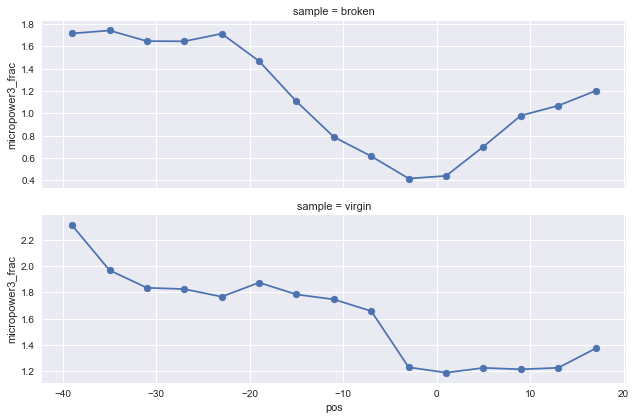

In [16]:
g = sns.FacetGrid(dfr, row='sample', sharey=False, size=3, aspect=3)

    
g.map(plotter , 'pos', 'micropower3_frac')
pl.savefig('harmonic_power.pdf')

In [17]:
dfr.head()

,sample,pos,z_amp,z_phase,micropower3_frac
0,broken,-39,14.622019,-41.003232,1.715339
1,broken,-35,20.731454,-33.725765,1.741907
2,broken,-31,21.864260,-30.768776,1.646615
3,broken,-27,21.852928,-29.497669,1.645157
4,broken,-23,21.814354,-28.905302,1.713347


In [18]:
dfx = dfr.set_index(['sample', 'pos']).unstack('sample').sort_index(axis=1)
dfx

micropower3_frac                z_amp               z_phase           
sample           broken    virgin     broken     virgin     broken     virgin
pos                                                                          
-39            1.715339  2.308817  14.622019  14.472237 -41.003232 -42.145210
-35            1.741907  1.968183  20.731454  20.232075 -33.725765 -35.018959
-31            1.646615  1.834929  21.864260  21.463994 -30.768776 -31.674611
-27            1.645157  1.825293  21.852928  21.587709 -29.497669 -30.155623
-23            1.713347  1.767264  21.814354  21.561078 -28.905302 -29.807505
-19            1.467574  1.874548  21.235480  21.783648 -28.556198 -29.463375
-15            1.106294  1.784292  20.572099  21.597278 -29.394193 -29.477000
-11            0.788635  1.746952  19.739030  21.440830 -30.271541 -29.478597
-7             0.615839  1.658082  18.341488  21.016007 -31.250494 -29.463879
-3             0.416607  1.231472  17.485864  20.529008 -31.098344 -29.736006
 1             0.440304  1.190704  17.319634  20.273166 -29.876748 -30.149150
 5             0.702361  1.227000  17.971373  20.277603 -30.082495 -30.582278
 9             0.980119  1.216124  18.821473  20.129634 -29.542242 -31.011935
 13            1.068784  1.227493  19.117433  19.615947 -30.886567 -32.326715
 17            1.201723  1.374827  16.346379  16.840656 -35.752225 -36.237742

In [19]:
field = 'micropower3_frac'
field = 'z_amp'
dfy = dfx.loc[:, pd.IndexSlice[field]].reset_index()
dfy.columns.name = None
dfy.loc[:, 'delta'] = list(dfy.broken - dfy.virgin)
dfy.head()

,pos,broken,virgin,delta
0,-39,14.622019,14.472237,0.149783
1,-35,20.731454,20.232075,0.499379
2,-31,21.864260,21.463994,0.400266
3,-27,21.852928,21.587709,0.265219
4,-23,21.814354,21.561078,0.253276


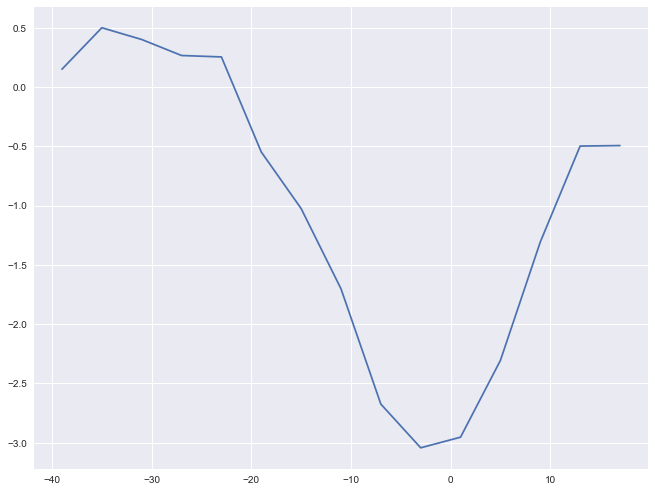

In [20]:
pl.plot(dfy.pos, dfy.delta)

In [ ]:
# # Code for plotting fits
# x = df.t
# y = df.sec_volt
# h = Harmonic(harmonics=[1, 3])
# h.fit(x, y, alpha=.0001, method='regression')
# y_fit = h.predict(x)
# resid = y - y_fit
# b, a = signal.butter(2, 0.001)
# resid_smooth = signal.filtfilt(b, a, resid, padlen=150)
# (
#     shade(hv.Curve((x, y)))
#     * shade(hv.Curve((x, y_fit), kdims=['time'], vdims=['amp']), color='red')
#     + (
#         shade(hv.Curve((x, resid), vdims=['resid']), color='blue')
#         *shade(hv.Curve((x, resid_smooth)), color='red')
#     )
        
    
# ).cols(1)

In [ ]:
class Pipe:
    def __init__(self, pipe, df_log_for_pipe, data_dir=None, n_jobs=1, verbose=True):
        """
        Initialize processor with a dataframe containing the batch
        of files that belong to one pipe.
        
        The Dataframe must always contain the columns "pos" and "file_name".
        All other columns are ignored.
        
        pipe = any python object that identifies the pipe
        data_dir = path_to_csv_data_files (defaults to "./")
        n_jobs = the number of jobs to run in parallel
        """
        self.n_jobs = n_jobs
        self.harmonics = [1, 3]
        self.pipe = pipe
        self.data_dir = data_dir
        self.verbose = verbose
        
        fields = ['pos', 'file_name']
        self.df_log = df_log_for_pipe[fields].sort_values(by=fields)
        self._df = None
        
    @property
    def df(self):
        return self._df.copy()
    @property
    def df_indexed(self):
        return self._indexify(self._df)
        
    @property
    def column_descriptions(self):
        return textwrap.dedent(
            """
            Column descriptions for result dataframe.
            
            'pipe': any python object used to uniquely identify a pipe (usually a string or a number)
            'pos': the position of a given measurement
            'prim_sec_amp': amplitude of V_secondary / I_primary
            'prim_sec_phi': phase of V_secondary / I_primary
            'prim_rec_amp': amplitude of V_receiver / I_primary
            'prim_rec_phi: phase of V_receiver / I_primary
            'sec_rec_amp': amplitude of V_receiver / V_secondary
            'sec_rec_phi': phase of V_receiver / V_secondary
            'sec_harm_db': third harmonic power fraction of secondary in dB
            'rec_harm_db': third harmonic power fraction of receiver in dB
            """
        )
        
    def _process_file(self, pos, file_name):
        if self.verbose:
            print(f'Processing {self.pipe}, {pos}, {file_name}')
        
        df = CSV(file_name=file_name, max_sample_freq=1e9,  **channel_mapper).df
        
        # In everything below the h_ prefix stands for "harmonic" because the
        # variable contains an instance of a harmonic object.

        # fit the primary current
        h_i_prim = Harmonic(harmonics=self.harmonics)
        h_i_prim.fit(df.t, df.res_volt)

        # fit the secondary voltage
        h_v_sec = Harmonic(harmonics=self.harmonics)
        h_v_sec.fit(df.t, df.sec_volt)
        
        # fit the receiver voltage
        h_v_rec = Harmonic(harmonics=self.harmonics)
        h_v_rec.fit(df.t, df.rec_volt)

        # compute "impedence" objects
        h_z_prim_sec = h_v_sec / h_i_prim
        h_z_prim_rec = h_v_rec / h_i_prim
        h_z_sec_rec = h_v_rec / h_v_sec 


        # populate some results
        rec = dict(
            # identifying information for this row
            pipe=self.pipe,
            pos=pos,
            
            # the "impedence" of secondary with respect to primary
            prim_sec_amp=h_z_prim_sec.amplitudes[0],
            prim_sec_phi=h_z_prim_sec.phases[0],
            
            # the "impedence" of receiver with respect to primary
            prim_rec_amp=h_z_prim_rec.amplitudes[0],
            prim_rec_phi=h_z_prim_rec.phases[0],
            
            # the "impedence" of receiver with respect to secondary
            sec_rec_amp=h_z_sec_rec.amplitudes[0],
            sec_rec_phi=h_z_sec_rec.phases[0],
            
            # the relative power in the 3rd harmonic expressed in db
            sec_harm_db = 10*np.log10(h_v_sec.amplitudes[1] ** 2 / np.sum(h_v_sec.amplitudes ** 2)),
            rec_harm_db = 10*np.log10(h_v_rec.amplitudes[1] ** 2 / np.sum(h_v_rec.amplitudes ** 2)),
        )
        return rec        
        
        
    def process(self, indexed=False):
        """
        Process all files belonging to a single pipe.
        
        indexed=True will create multi-indexes for rows and columns
        """
        
        def fake_delayed(func):
            """
            This behaves as a mock for dask.delayed when you are debugging
            and don't want parallel execution.  It just returns the "delayed"
            function without applying any delay.
            """
            return func
        
        def fake_compute(*future_list, **kwargs):
            """
            This bahaves as a mock for dask.compute when you are debugging and
            don't want parallel execution.  In this case, the "futures" are just
            the actual results returned by the non-delayed functions wrapped by
            the fake_delay function.
            """
            return future_list
        
        # if instructed to run in parallel, use dask.delayed and dask.compute
        # otherwise just use the mocks
        if self.n_jobs > 1:
            delay_func = delayed
            compute_func = compute
        else:
            delay_func = fake_delayed
            compute_func = fake_compute
            
        # initialize a list to hold futures
        future_list = []
            
        # loop over all files for this pipe and process them
        for pos, file_name in zip(self.df_log.pos, self.df_log.file_name):
            # add path to file_name if needed
            if self.data_dir is not None:
                file_name = os.path.join(self.data_dir, file_name)
                
            # create a future (this directly evalutes the function if n_jobs < 2)
            future = delay_func(self._process_file)(pos, file_name)
            future_list.append(future)
        # evaluate all futures (if n_jobs < 2), this just puts results into the rec_list
        rec_list = list(compute_func(*future_list, get=dask.multiprocessing.get))
        
        # specify proper column ordering for output
        columns=[
            'pipe',
            'pos',
            'prim_sec_amp',
            'prim_sec_phi',
            'prim_rec_amp',
            'prim_rec_phi',
            'sec_rec_amp',
            'sec_rec_phi',
            'sec_harm_db',
            'rec_harm_db',
        ]
        
        # create and return a results frame
        df = pd.DataFrame(rec_list, columns=columns)
        self._df = df
        
        return self.df
            
    def _indexify(self, df):
        arrays = [
            ['primary', 'primary', 'primary', 'primary', 'sec', 'sec', 'primary', 'primary'],
            ['secondary', 'secondary', 'receiver', 'receiver', 'receiver', 'receiver', 'secondary', 'secondary'],
            ['amplitude', 'phase', 'amplitude', 'phase', 'amplitude', 'phase', 'db', 'db']
        ]
        
        df = df.set_index(['pipe', 'pos'])
        df.columns = pd.MultiIndex.from_arrays(arrays, names=['driver', 'detector', 'quantity'])
        df = df.sort_index(axis=1).sort_index()
        return df